In [1]:
"""
fourier_burgers_equation.ipynb

Created on Sat Apr 15 2023

@authors: Luca d'Amico-Wong, Lukas Fesser, and Richard Qiu

This file contains code to train a PINN with (random) Fourier feature
mappings to solve the 1D Burgers equation
"""

"\nfourier_burgers_equation.ipynb\n\nCreated on Sat Apr 15 2023\n\n@authors: Luca d'Amico-Wong, Lukas Fesser, and Richard Qiu\n\nThis file contains code to train a PINN with (random) Fourier feature\nmappings to solve the 1D Burgers equation\n"

For a given field $u(x, t)$, the viscous Burger's equation is given by $$\frac{\delta u}{\delta t} + u\frac{\delta u}{\delta x} = \nu \frac{\delta^2 u}{\delta x^2}$$
Here, we consider $x \in [-1, 1]$ and $t \in [0, 0.5]$. We use the Dirichley boundary conditions and initial conditions
$$ u(-1, t) = u(1, t) = 0 \text{ , } u(x, 0) = -\sin(\pi x)$$
We train an MLP with tanh activation with the Burger's equation as part of the loss function and compare its accuracy in an intrapolation and extrapolation setting.

In [1]:
# install deepxde

%pip install deepxde

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 7.4 MB/s eta 0:00:00


In [2]:
# import packages

import deepxde as dde

import numpy as np

import torch

import matplotlib.pyplot as plt

if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)

No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)
Enable just-in-time compilation with XLA.



In [3]:
torch.cuda.is_available()

device = torch.device("cuda")

In [4]:
# define the PDE

def pde(x, y):
    dy_x = dde.grad.jacobian(y, x, i=0, j=0)
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t + y * dy_x - 0.01 / np.pi * dy_xx

In [5]:
# define a computational geometry and a time domain

geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 0.5)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

In [6]:
# define the boundary and initial conditions

bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(geomtime, lambda x: -np.sin(np.pi * x[:, 0:1]), lambda _, on_initial: on_initial)

In [7]:
# define the time PDE problem

data = dde.data.TimePDE(geomtime, pde, [bc, ic],
                        num_domain=25400, num_boundary=80, num_initial=160)

In [8]:
# choose the network architecture and the training method

layer_size = [2] + [50] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"

net = dde.nn.MsFFN(layer_size, activation, initializer, sigmas=[0.5])

model = dde.Model(data, net)

model.compile("adam", lr=1e-5, loss_weights=[1, 1, 1])

Compiling model...
Building Multiscale Fourier Feature Network...


/usr/local/lib/python3.9/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:114: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 3.457446 s



In [23]:
# train the model

losshistory, train_state = model.train(iterations=50000)

Training model...

Step      Train loss                        Test loss                         Test metric
50000     [2.99e-05, 8.17e-08, 8.97e-06]    [2.99e-05, 8.17e-08, 8.97e-06]    []  
51000     [3.04e-05, 1.11e-07, 9.22e-06]    [3.04e-05, 1.11e-07, 9.22e-06]    []  
52000     [2.76e-05, 7.07e-08, 7.56e-06]    [2.76e-05, 7.07e-08, 7.56e-06]    []  
53000     [2.65e-05, 6.60e-08, 7.03e-06]    [2.65e-05, 6.60e-08, 7.03e-06]    []  
54000     [2.55e-05, 6.26e-08, 6.53e-06]    [2.55e-05, 6.26e-08, 6.53e-06]    []  
55000     [2.45e-05, 5.91e-08, 6.12e-06]    [2.45e-05, 5.91e-08, 6.12e-06]    []  
56000     [2.36e-05, 5.61e-08, 5.74e-06]    [2.36e-05, 5.61e-08, 5.74e-06]    []  
57000     [2.32e-05, 5.95e-08, 5.58e-06]    [2.32e-05, 5.95e-08, 5.58e-06]    []  
58000     [2.20e-05, 5.07e-08, 5.03e-06]    [2.20e-05, 5.07e-08, 5.03e-06]    []  
59000     [2.12e-05, 4.87e-08, 4.71e-06]    [2.12e-05, 4.87e-08, 4.71e-06]    []  
60000     [2.05e-05, 4.64e-08, 4.45e-06]    [2.05e-05, 4.64e-

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


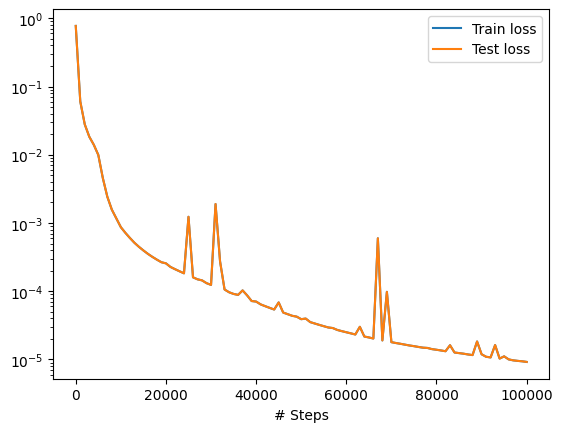

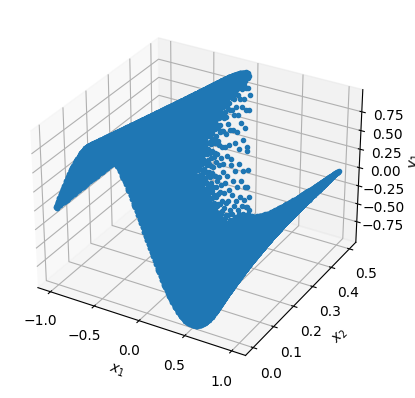

In [24]:
# plot the loss function for the governing equation

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

In [9]:
# import data for the true solution

def gen_testdata():
    data = np.load("/content/Burgers.npz")
    t, x, exact = data["t"], data["x"], data["usol"].T
    xx, tt = np.meshgrid(x, t)
    X = np.vstack((np.ravel(xx), np.ravel(tt))).T
    y = exact.flatten()[:, None]
    return X, y

In [10]:
# compare the true solution with the predicted solution

X, y_true = gen_testdata()
y_pred = model.predict(X)
f = model.predict(X, operator=pde)
print("Mean residual:", np.mean(np.absolute(f)))
print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))

FailedPreconditionError: ignored

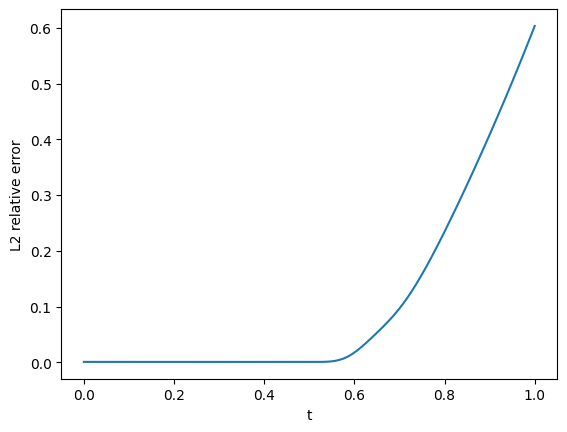

In [20]:
# compute the L2 relative error between the true solution and the predicted solution

rel_l2_errors = []

for i in range(0, 25600, 256):
    y_pred = model.predict(X[i:i+256])
    y_sol = y_true[i:i+256]

    # collect the relative L2 errors in a list
    rel_l2_errors.append(dde.metrics.l2_relative_error(y_sol, y_pred))


# plot the relative L2 errors

x = np.linspace(0, 1, 100)
plt.plot(x, rel_l2_errors)
plt.xlabel("t")
plt.ylabel("L2 relative error")
plt.show()

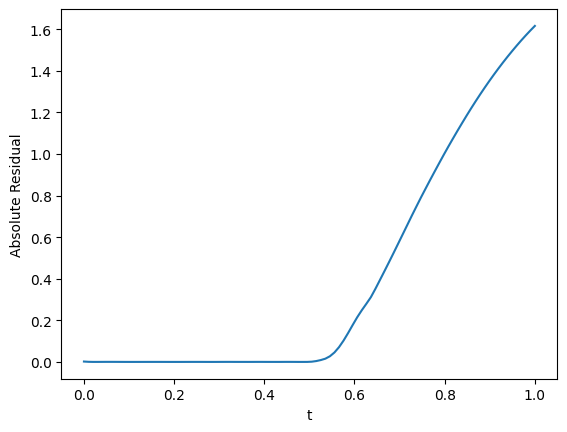

In [21]:
# compute the L2 relative error between the true solution and the predicted solution

absolute_residual = []

for i in range(0, 25600, 256):
    absolute_residual.append(np.mean(np.absolute(f)[i:i+256]))


# plot the relative L2 errors

x = np.linspace(0, 0.01 * 100, 100)
plt.plot(x, absolute_residual)
plt.xlabel("t")
plt.ylabel("Absolute Residual")
plt.show()

Note that we only trained with $t \in [0, 0.5]$, for which the error is generally low. As soon as we enter an extrapolation setting ($t \in [0.5, 1]$), the error seems to increase linearly (?) in $t$. We tried this for several architectures and learning rates, but always observe the same general trend.

The below plots visualize this increase in the L2-error further. Note that the first to plots are in an intrapolation setting ($t = 0$ and $t = 0.5$), while the last three plots are outside of the training domain ($t = \{0.6, 0.7, 1\}$).

In [11]:
# interpolation and extrapolation errors during training

mean_residual_inter = []
mean_residual_extra = []

l2_error_inter = []
l2_error_extra = []

In [15]:
# record mean residuals and l2-errors over training epochs for t in [0, 1]

X, y_true = gen_testdata()

for i in range(200):
    model.train(iterations=1000)

    y_pred = model.predict(X)
    f = model.predict(X, operator=pde)

    mean_residual_inter.append(np.mean(np.absolute(f)[:12800]))
    l2_error_inter.append(dde.metrics.l2_relative_error(y_true[:12800], y_pred[:12800]))

    mean_residual_extra.append(np.mean(np.absolute(f)[12800:]))
    l2_error_extra.append(dde.metrics.l2_relative_error(y_true[12800:], y_pred[12800:]))

Training model...

Step      Train loss                        Test loss                         Test metric
200000    [3.66e-05, 8.95e-07, 6.02e-06]    [3.66e-05, 8.95e-07, 6.02e-06]    []  
201000    [3.64e-05, 8.89e-07, 6.00e-06]    [3.64e-05, 8.89e-07, 6.00e-06]    []  

Best model at step 201000:
  train loss: 4.33e-05
  test loss: 4.33e-05
  test metric: []

'train' took 13.662791 s

Training model...

Step      Train loss                        Test loss                         Test metric
201000    [3.64e-05, 8.89e-07, 6.00e-06]    [3.64e-05, 8.89e-07, 6.00e-06]    []  
202000    [3.62e-05, 8.85e-07, 5.91e-06]    [3.62e-05, 8.85e-07, 5.91e-06]    []  

Best model at step 202000:
  train loss: 4.30e-05
  test loss: 4.30e-05
  test metric: []

'train' took 13.745226 s

Training model...

Step      Train loss                        Test loss                         Test metric
202000    [3.62e-05, 8.85e-07, 5.91e-06]    [3.62e-05, 8.85e-07, 5.91e-06]    []  
203000    [3.59e-05, 8

KeyboardInterrupt: ignored

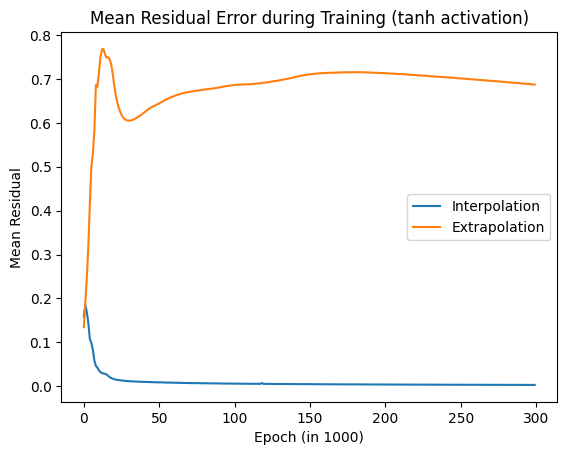

In [16]:
# plot the mean residual in interpolation and extrapolation against the training epochs

plt.plot([*range(300)], mean_residual_inter, label="Interpolation")
plt.plot([*range(300)], mean_residual_extra, label="Extrapolation")

plt.legend()
plt.title("Mean Residual Error during Training (tanh activation)")
plt.xlabel("Epoch (in 1000)")
plt.ylabel("Mean Residual")
plt.show()

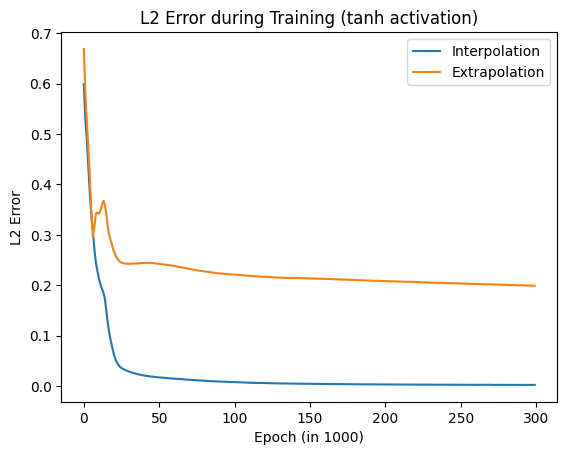

In [17]:
# plot the L2 error in interpolation and extrapolation against the training epochs

plt.plot([*range(300)], l2_error_inter, label="Interpolation")
plt.plot([*range(300)], l2_error_extra, label="Extrapolation")

plt.legend()
plt.title("L2 Error during Training (tanh activation)")
plt.xlabel("Epoch (in 1000)")
plt.ylabel("L2 Error")
plt.show()

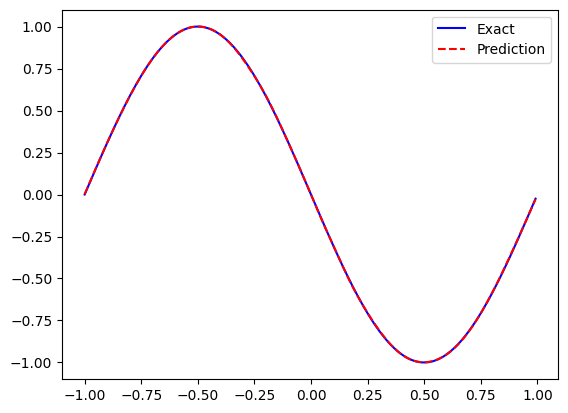

In [18]:
# plot the true solution and the predicted solution in interpolation

plt.figure()
plt.plot(X[:, 0][:255], y_true[:255], "b-", label="Exact")
plt.plot(X[:, 0][:255], y_pred[:255], "r--", label="Prediction")
plt.legend()
plt.show()

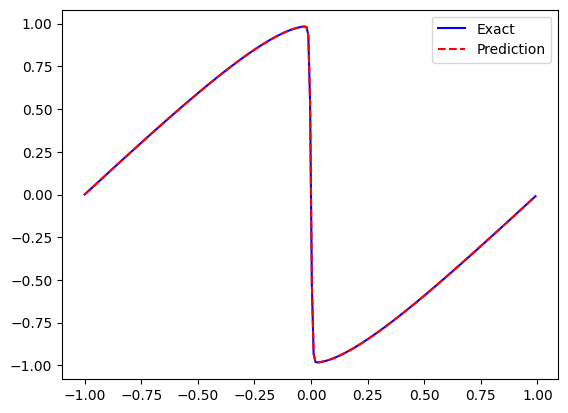

In [19]:
# plot the true solution and the predicted solution between interpolation and extrapolation

plt.figure()
plt.plot(X[:, 0][12800:13055], y_true[12800:13055], "b-", label="Exact")
plt.plot(X[:, 0][12800:13055], y_pred[12800:13055], "r--", label="Prediction")
plt.legend()
plt.show()

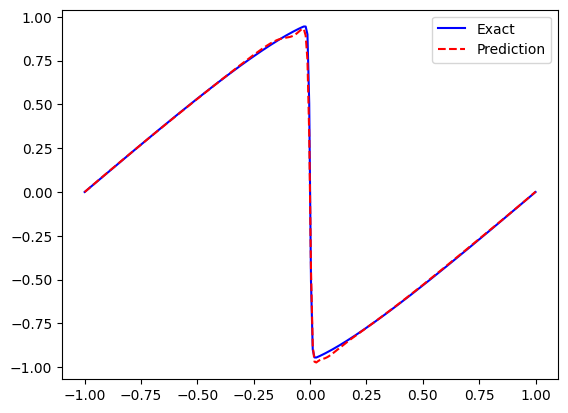

In [20]:
# plot the true solution and the predicted solution between interpolation and extrapolation

plt.figure()
plt.plot(X[:, 0][15360:15616], y_true[15360:15616], "b-", label="Exact")
plt.plot(X[:, 0][15360:15616], y_pred[15360:15616], "r--", label="Prediction")
plt.legend()
plt.show()

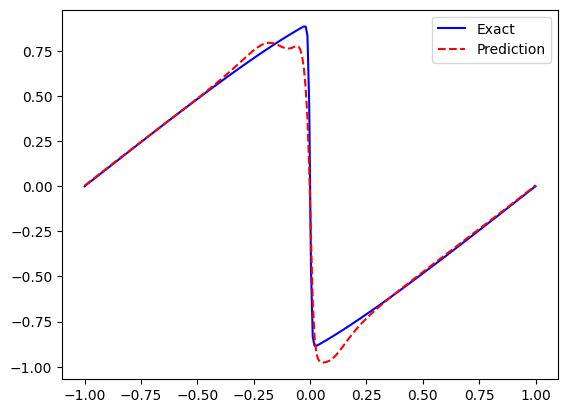

In [21]:
# plot the true solution and the predicted solution between interpolation and extrapolation

plt.figure()
plt.plot(X[:, 0][17920:18176], y_true[17920:18176], "b-", label="Exact")
plt.plot(X[:, 0][17920:18176], y_pred[17920:18176], "r--", label="Prediction")
plt.legend()
plt.show()

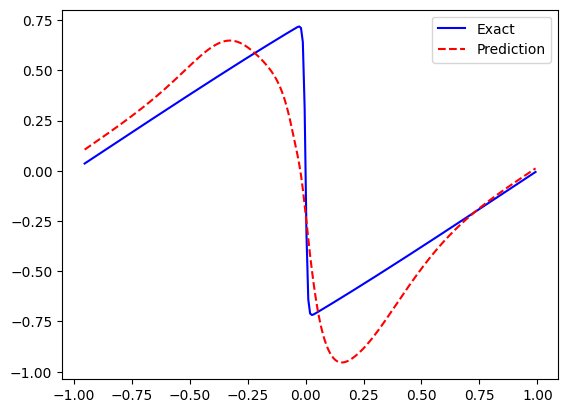

In [22]:
# plot the true solution and the predicted solution in extrapolation

plt.figure()
plt.plot(X[:, 0][25350:25599], y_true[25350:25599], "b-", label="Exact")
plt.plot(X[:, 0][25350:25599], y_pred[25350:25599], "r--", label="Prediction")
plt.legend()
plt.show()